<a href="https://colab.research.google.com/github/mpianforini/FloodSformer/blob/main/docs/demo/Demo_FS_RiverFlood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FloodSformer: real-time forecasting of river flood scenarios

This is a demo for the real-time forecasting of **river flood scenarios** using the FloodSformer model. Further details can be found in our paper ["Pianforini et al. (2024). A deep learning model for real-time forecasting of 2-D river flood inundation maps"](https://hess.copernicus.org/preprints/hess-2024-176/) and in the [GitHub repository](https://github.com/mpianforini/FloodSformer). \

Toce River flood case study.

The resulting output maps (target, predicted and differences maps) will be stored in the designated output folder. Users have the capability to download the entire folder for convenient access.

Note: please use a GPU if available.

In [1]:
import torch
import os
import sys

# check whether run in Colab
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    # Intall the packages
    !pip install torchmetrics -q
    !pip install simplejson -q
    !pip install einops -q
    !pip install psutil -q
    !pip install timm -q
    !pip install opencv-python -q
    !pip install -U fvcore -q
    !pip install zenodo-get -q
else:
    sys.path.append('..')
    print("WARNING! You are not running on Colab. Ensure all necessary packages are installed before proceeding.")

Running in Colab.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.6/962.6 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (se

In [2]:
# Clone the GitHub repository
print('Cloning the GitHub repository...')
!git clone https://github.com/mpianforini/FloodSformer.git
sys.path.append('./FloodSformer')
if os.getcwd() != '/content/FloodSformer':
  os.chdir('FloodSformer/')

# Clone the Zenodo repository (dataset and weights)
print('\nCloning the Zenodo repository...')
!zenodo_get '10.5281/zenodo.11472228'
!unzip -q -o 'FS_RiverFlood_dataset&checkpoints.zip'
!rm 'FS_RiverFlood_dataset&checkpoints.zip'

Cloning the GitHub repository...
Cloning into 'FloodSformer'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (118/118), done.
remote: Total 203 (delta 100), reused 173 (delta 81), pack-reused 0 (from 0)
Receiving objects: 100% (203/203), 3.70 MiB | 12.54 MiB/s, done.
Resolving deltas: 100% (100/100), done.

Cloning the Zenodo repository...
Title: FloodSformer: River Flood datasets&checkpoints
Keywords: transformer, River flood
Publication date: 2024-06-04
DOI: 10.5281/zenodo.11472228
Total size: 2.6 GB

File: FS_RiverFlood_dataset&checkpoints.zip (2.6 GB)
Link: https://zenodo.org/api/records/11472228/files/FS_RiverFlood_dataset&checkpoints.zip/content

Checksum is correct for FS_RiverFlood_dataset&checkpoints.zip. (106d652ea4f955b0692e2d44583d2bd7)

All specified files have been processed.


***
## Run the real-time forecasting

In [3]:
### PARAMETERS ###

# Training configuration ->  choose between "Toce1" and "Toce2"
train_config = "Toce2"

In [4]:
### PREDICTION ###
from docs.demo.demo_utils import set_config, run_RTforecast
from floodsformer.config.defaults import _assert_and_infer_cfg

past_frames = 1  # P: number of past frames (P < 9)
future_frames = 107 - past_frames

if train_config == "Toce1":
  chkpt_AE_dir = 'Toce/checkpoint/Toce1/AE_Toce1_e188.tar'
  chkpt_VPTR_dir = 'Toce/checkpoint/Toce1/VPTR_Toce1_e96.tar'
  download_name = 'Toce1_Results_P{}_F{}'.format(past_frames, future_frames)
  print("Toce River case study - Toce1 training configuration")
elif train_config == "Toce2":
  chkpt_AE_dir = 'Toce/checkpoint/Toce2/AE_Toce2_e349.tar'
  chkpt_VPTR_dir = 'Toce/checkpoint/Toce2/VPTR_Toce2_e102.tar'
  download_name = 'Toce2_Results_P{}_F{}'.format(past_frames, future_frames)
  print("Toce River case study - Toce2 training configuration")
else:
  raise NotImplementedError("Available training configurations: Toce1 or Toce2")

dataset_dir = 'Toce/dataset_test/'
cfg_file = 'configs/River_flood/Toce_testFS.yaml'

print("Past frames = {}".format(past_frames))
print("Future frames = {}".format(future_frames))

assert past_frames < 9 and past_frames > 0

# Setup cfg.
cfg = set_config(cfg_file, past_frames, future_frames, chkpt_AE_dir, chkpt_VPTR_dir, dataset_dir)

if torch.cuda.is_available():
  cfg.NUM_GPUS = 1
  print("Run using GPU")
  print("Num GPUs Available: ", torch.cuda.device_count())
  !nvidia-smi -L
else:
  cfg.NUM_GPUS = 0
  print("WARNING: running using CPU. High computational time!\n")
  print("CPU type:")
  !cat /proc/cpuinfo | grep "model name" | head -1
  print("Number of cores:")
  !cat /proc/cpuinfo | grep "model name" | wc -l

# Make some assertions.
cfg = _assert_and_infer_cfg(cfg)

# Run the real-time forecasting procedure.
save_dir, renorm_transform = run_RTforecast(cfg)
print("Output grids saved in: {}".format(save_dir))

/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Toce River case study - Toce2 training configuration
Past frames = 1
Future frames = 106

CPU type:
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
Number of cores:
2
[06/26 02:18:15][INFO] demo_utils.py: 292: ### Real-time forecasting ###
[06/26 02:18:15][INFO] build.py:  43: [~] Creating the real-time forecast dataset...
[06/26 02:18:15][INFO] parflood.py:  60: Considering the inflow discharge!
[06/26 02:18:15][INFO] preprocessing.py: 155: Maps information:
						- Grid type: DSBB
						- Grid size: 0.05
						- X Minimum: 0.4
						- X Maximum: 6.75
						- Y Minimum: 2.35
						- Y Maximum: 8.7
						- Number of cells: 16384
[06/26 02:18:15][INFO] build.py:  46: Number of predicted frames: 106
[06/26 02:18:15][INFO] build.py:  47: Number of iterations: 1
[06/26 02:18:15][INFO] parflood.py: 171: AR_forecast dataset created:	4 sequences	4 batches	0.026 GB RAM dataset size	0.007 GB RAM batch size.


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[06/26 02:18:16][INFO] ResNetAutoEncoder.py: 217: Initialize VPTR_Enc model with normal.
[06/26 02:18:16][INFO] ResNetAutoEncoder.py: 217: Initialize VPTR_Dec model with normal.
[06/26 02:18:16][INFO] checkpoint.py:  86: Loading AE preatrained model from: Toce/checkpoint/Toce2/AE_Toce2_e349.tar
[06/26 02:18:16][INFO] checkpoint.py:  94: Loading VPTR_Enc:
[06/26 02:18:16][INFO] checkpoint.py: 110: <All keys matched successfully>
[06/26 02:18:16][INFO] checkpoint.py:  94: Loading VPTR_Dec:
[06/26 02:18:16][INFO] checkpoint.py: 110: <All keys matched successfully>
[06/26 02:18:17][INFO] ResNetAutoEncoder.py: 217: Initialize VPTR_Transformer model with normal.
[06/26 02:18:17][INFO] checkpoint.py: 138: Transformer: loading pretrained model from Toce/checkpoint/Toce2/VPTR_Toce2_e102.tar
[06/26 02:18:19][INFO] checkpoint.py: 146: Loading VPTR_Transformer:
[06/26 02:18:20][INFO] checkpoint.py: 439: <All keys matched successfully>
[06/26 02:18:20][INFO] checkpoint.py: 445: Loading optimizer_T


***
## Print ground-truth and predicted maps
- The first row of the figure represents the ground-truth maps obtained with the PARFLOOD code (numerical model).
- The second row reports the maps predicted by the FloodSformer model (surrogate model).
- The last row represents the difference between predicted and ground-truth maps.

Past frames: 1
Future frames: 106
Gradual hydrograph:


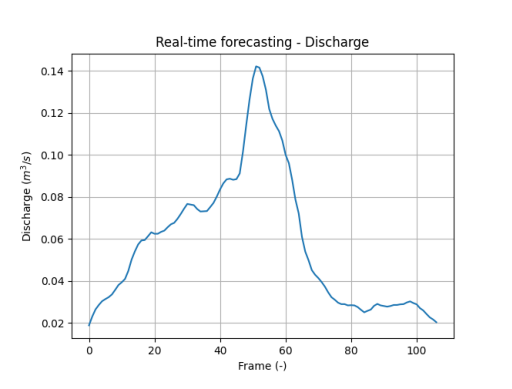

Prediction:


High hydrograph:


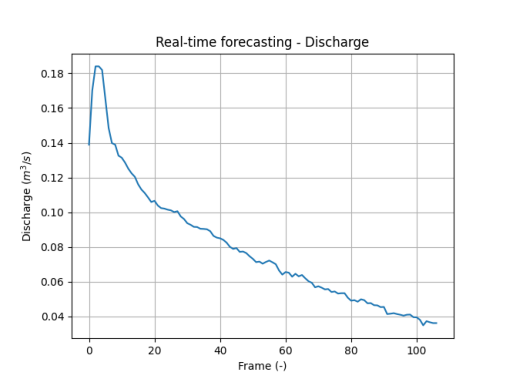

Prediction:


Low hydrograph:


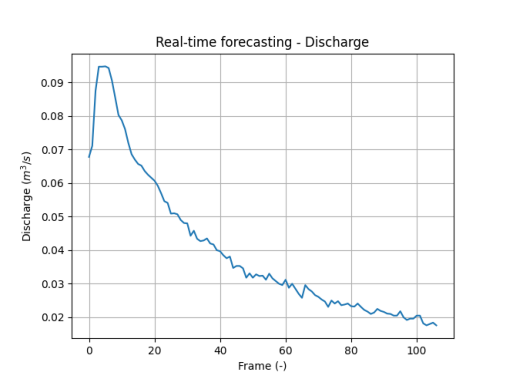

Prediction:


Medium hydrograph:


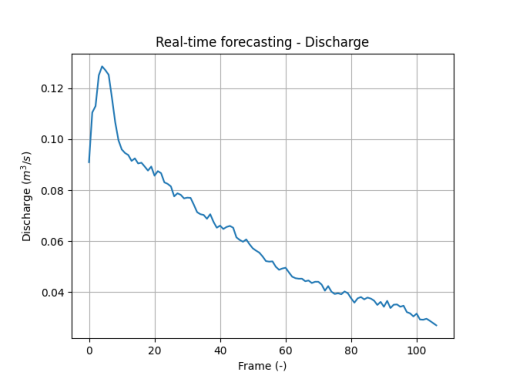

Prediction:


In [5]:
from docs.demo.demo_utils import MapToImage

MapToImage(cfg, save_dir, renorm_transform, n_output=4)

### Plot the RMSE

Gradual hydrograph


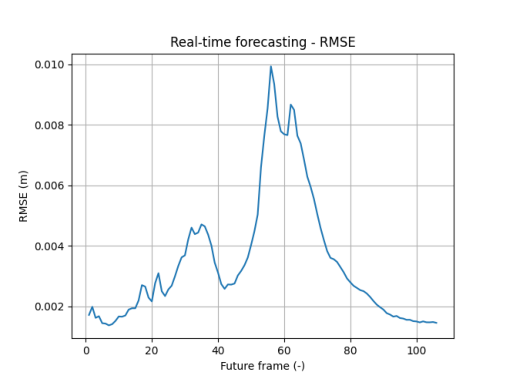

High hydrograph


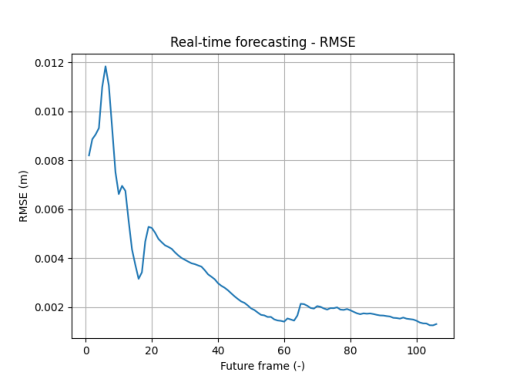

Low hydrograph


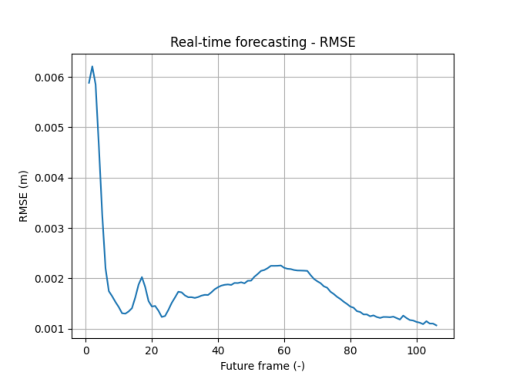

Medium hydrograph


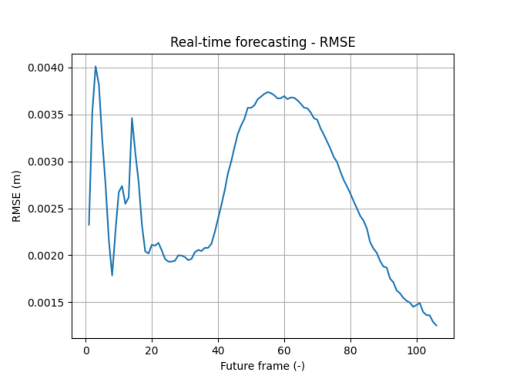

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

output_name = ["Gradual hydrograph", "High hydrograph", "Low hydrograph", "Medium hydrograph"]
for n in range(4):
    print(output_name[n])
    img = mpimg.imread(os.path.join(save_dir, f'plot_rmse_seq_{n}.png'))
    plt.imshow(img, origin='upper')
    plt.axis('off')
    plt.show()

### Extract water depths at control points (P2-P10)

Gradual flood scenario:


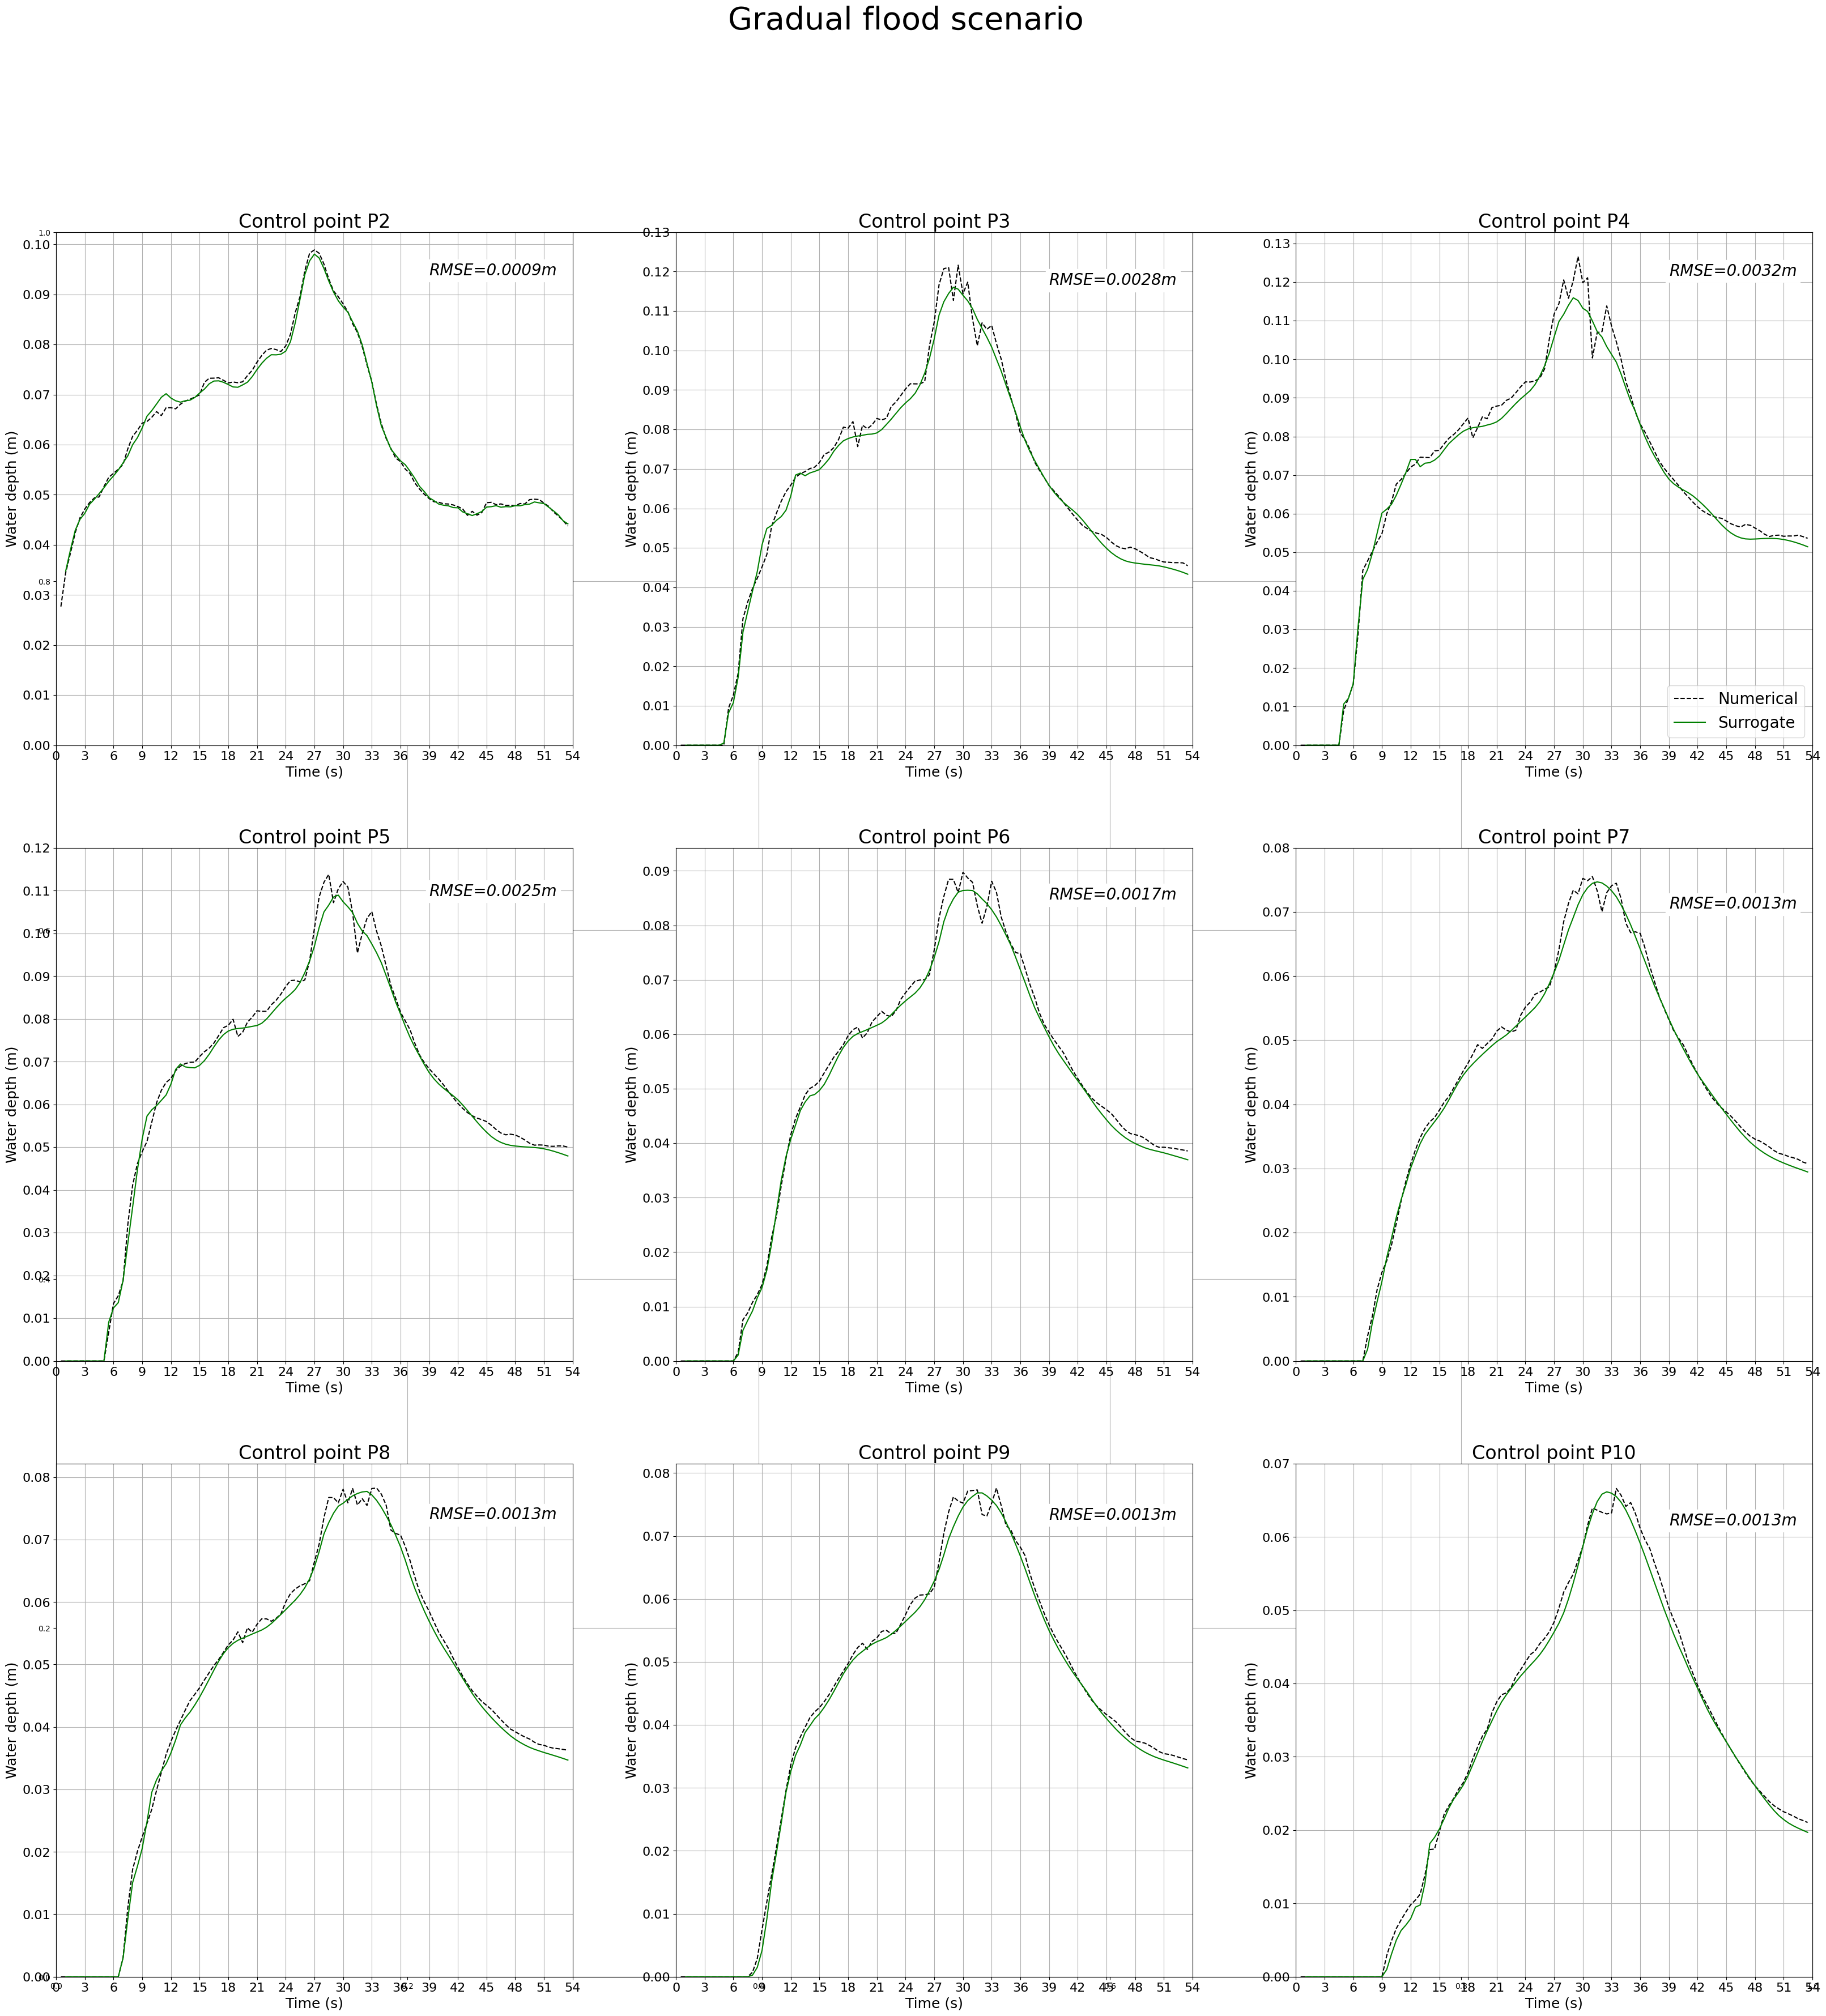

High flood scenario:


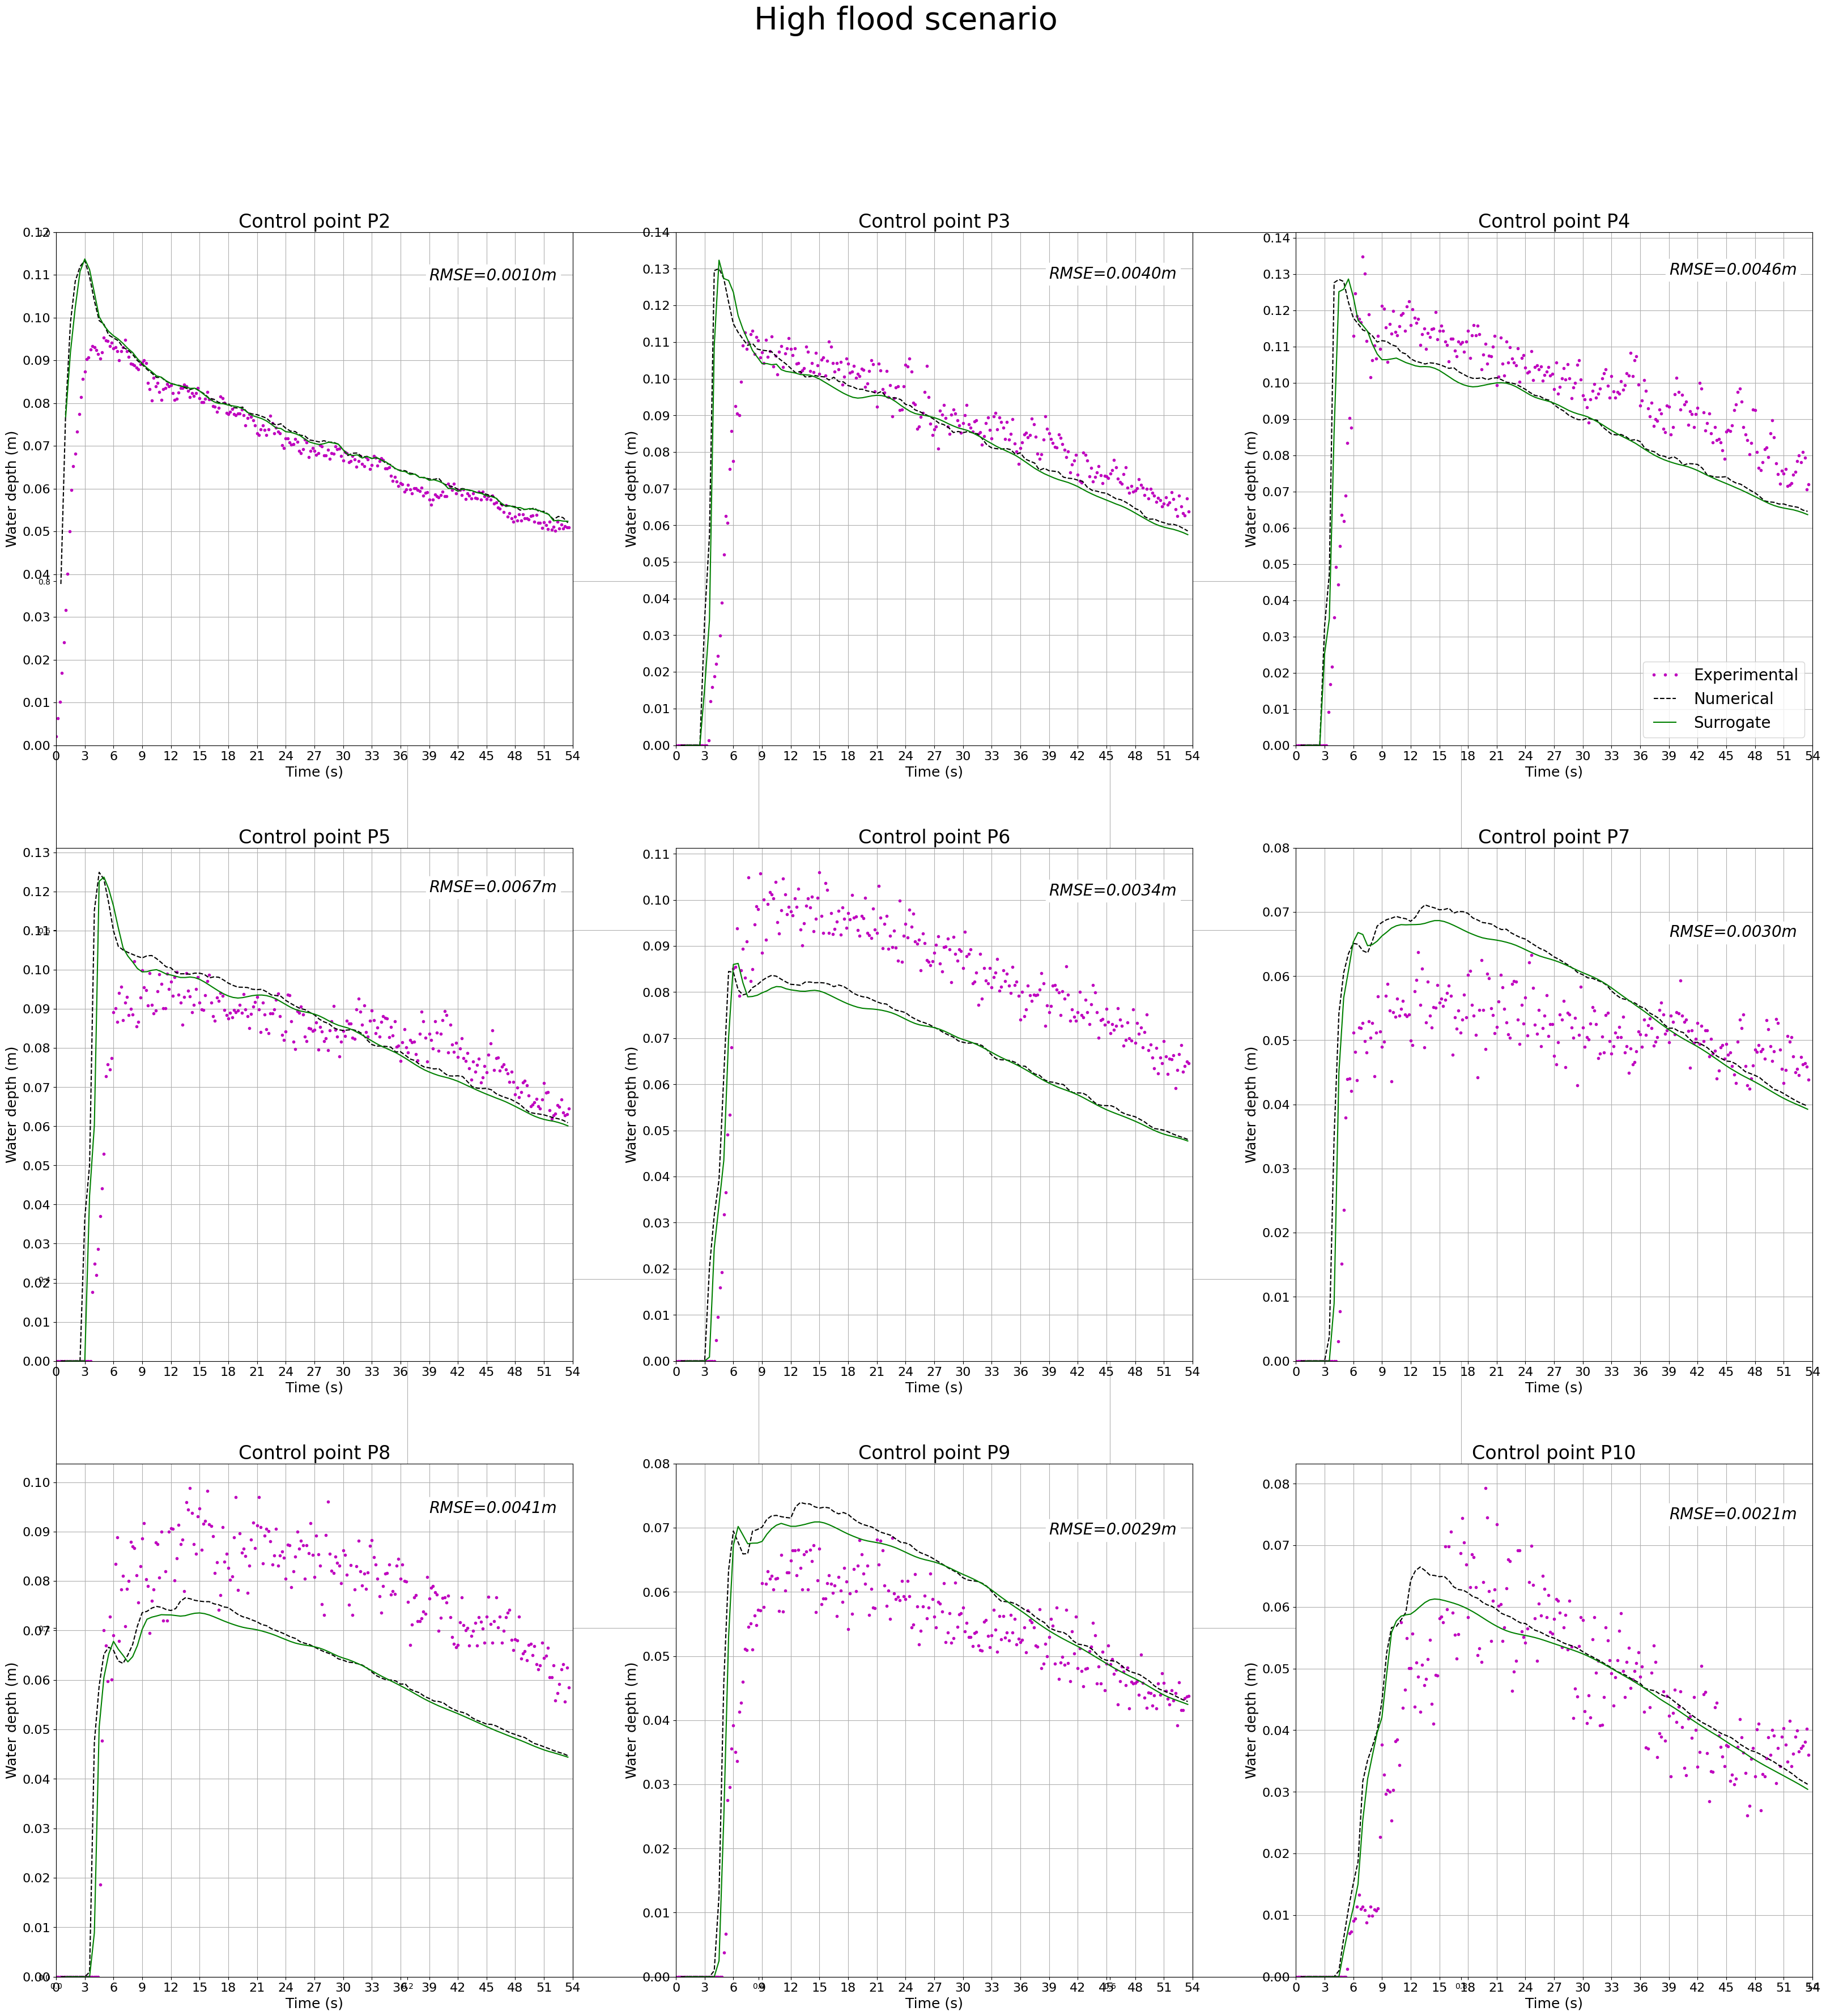

Low flood scenario:


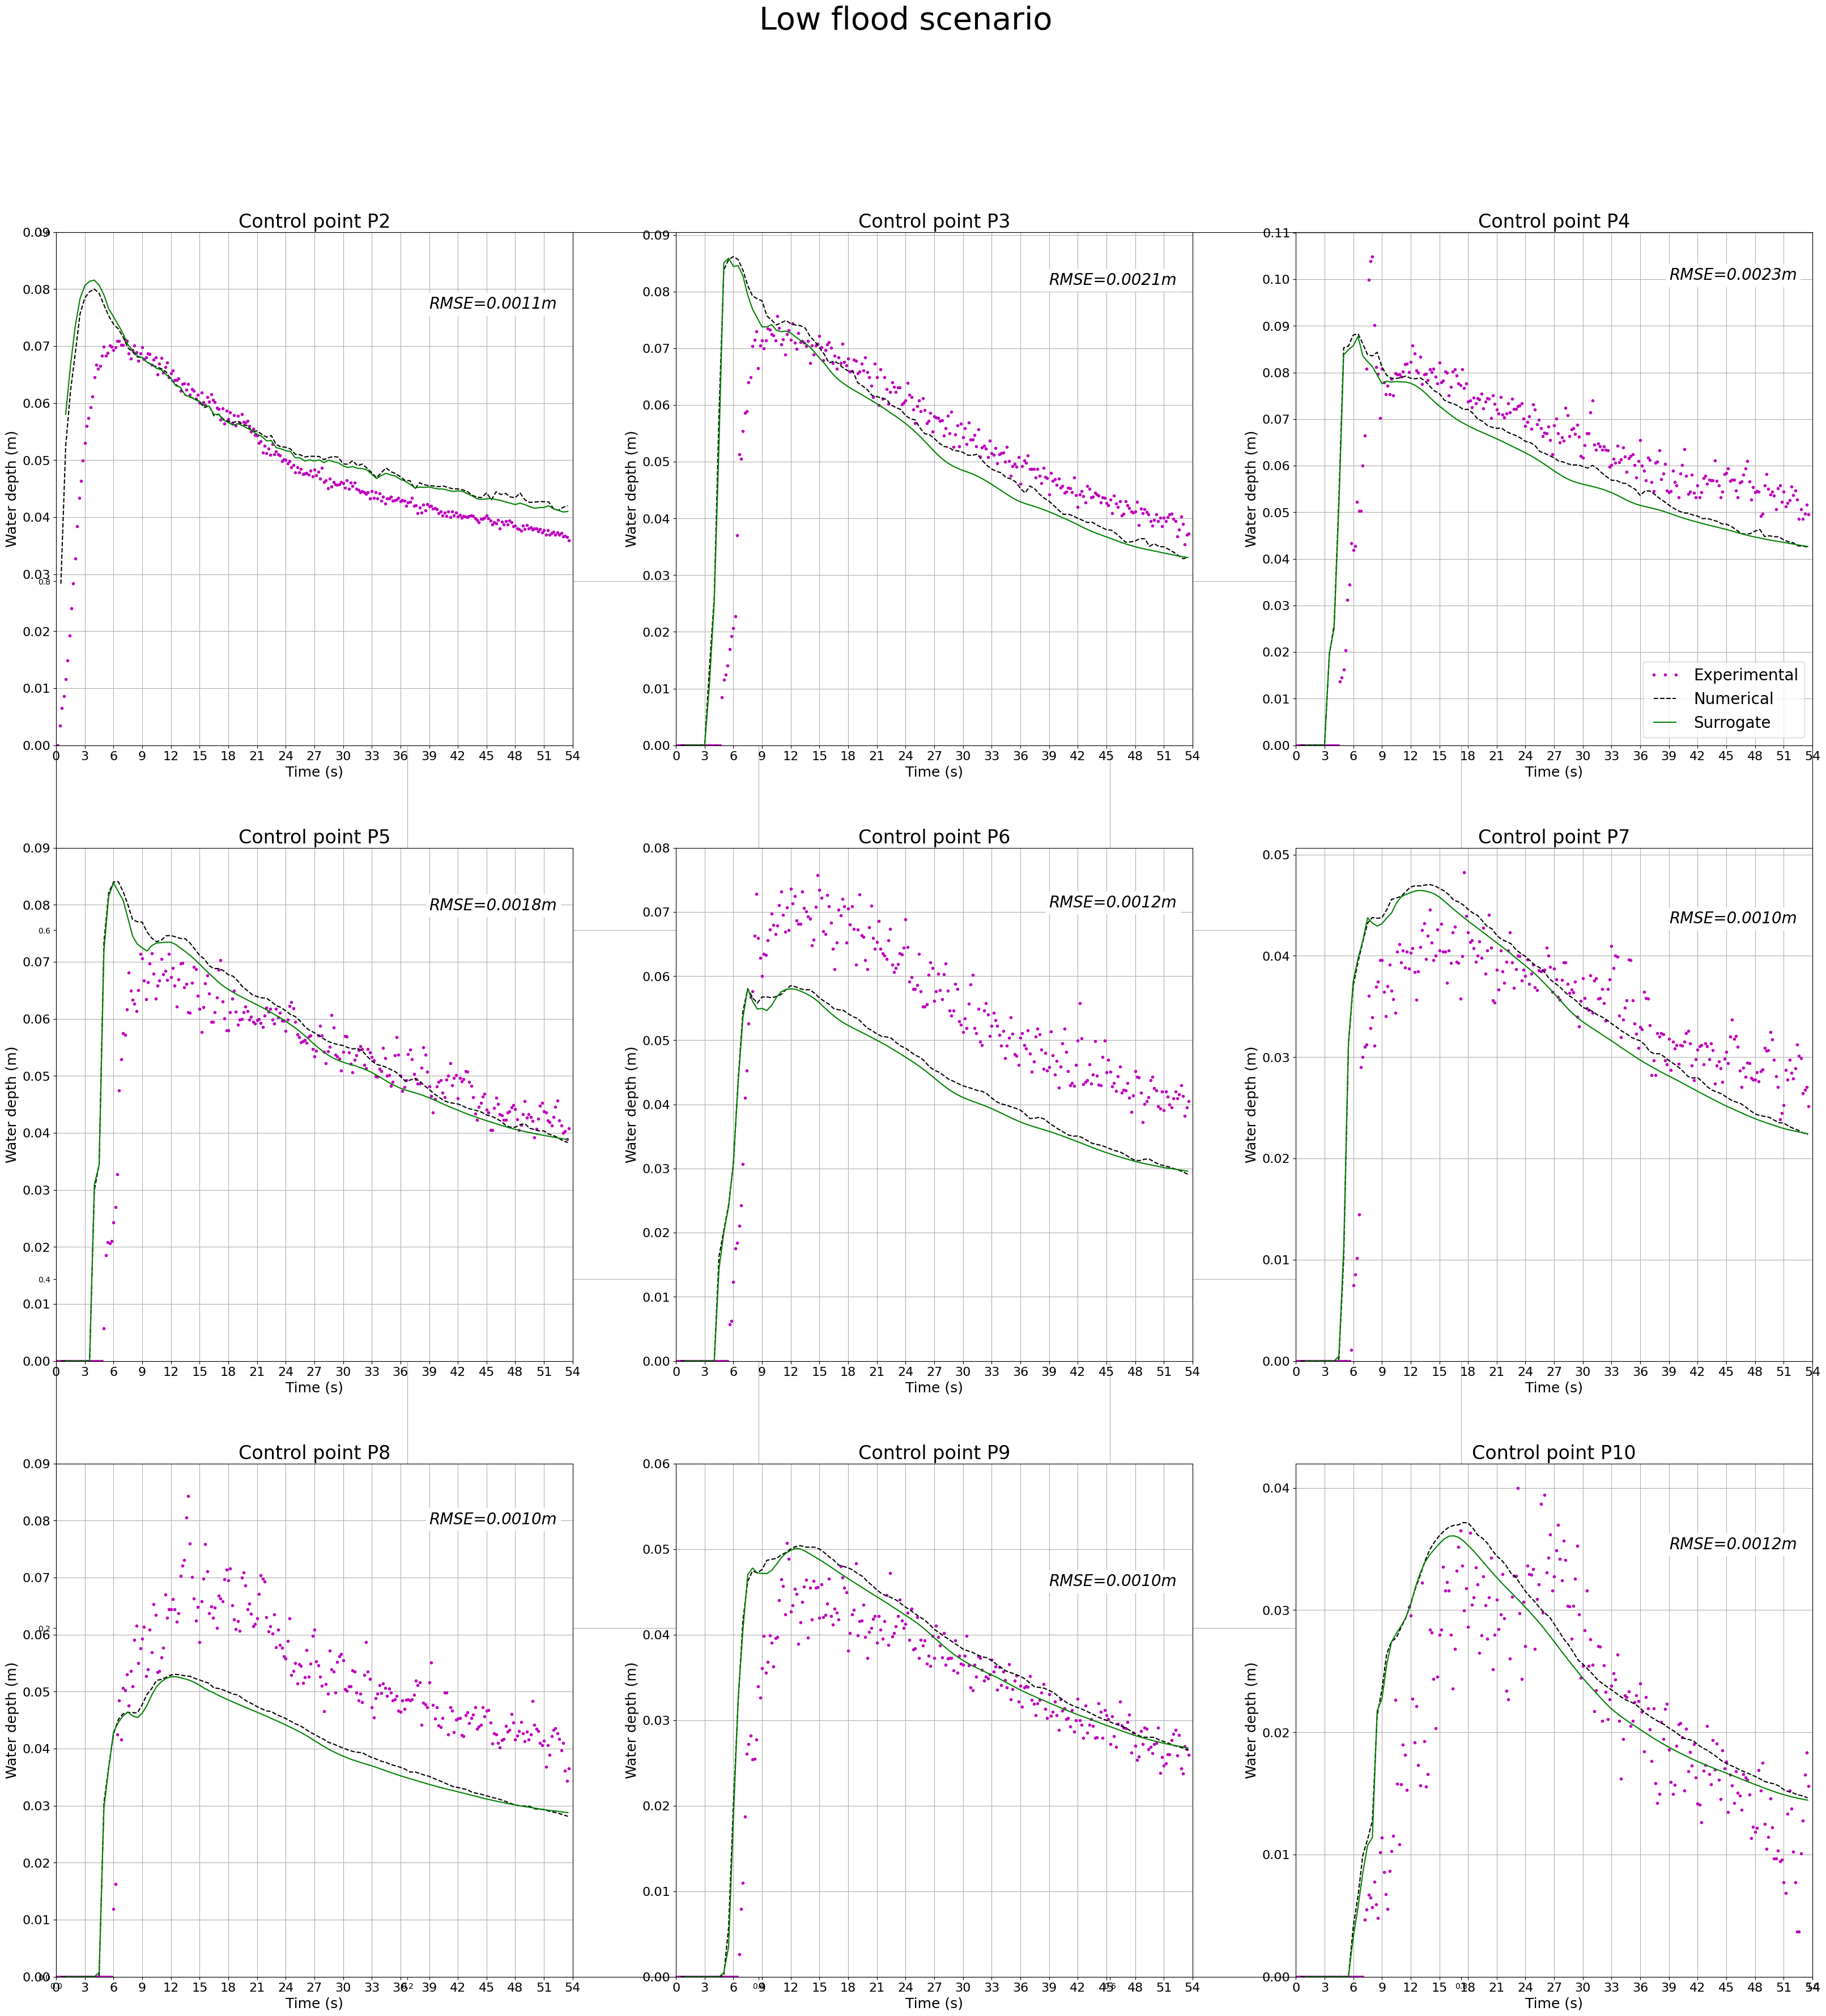

Medium flood scenario:


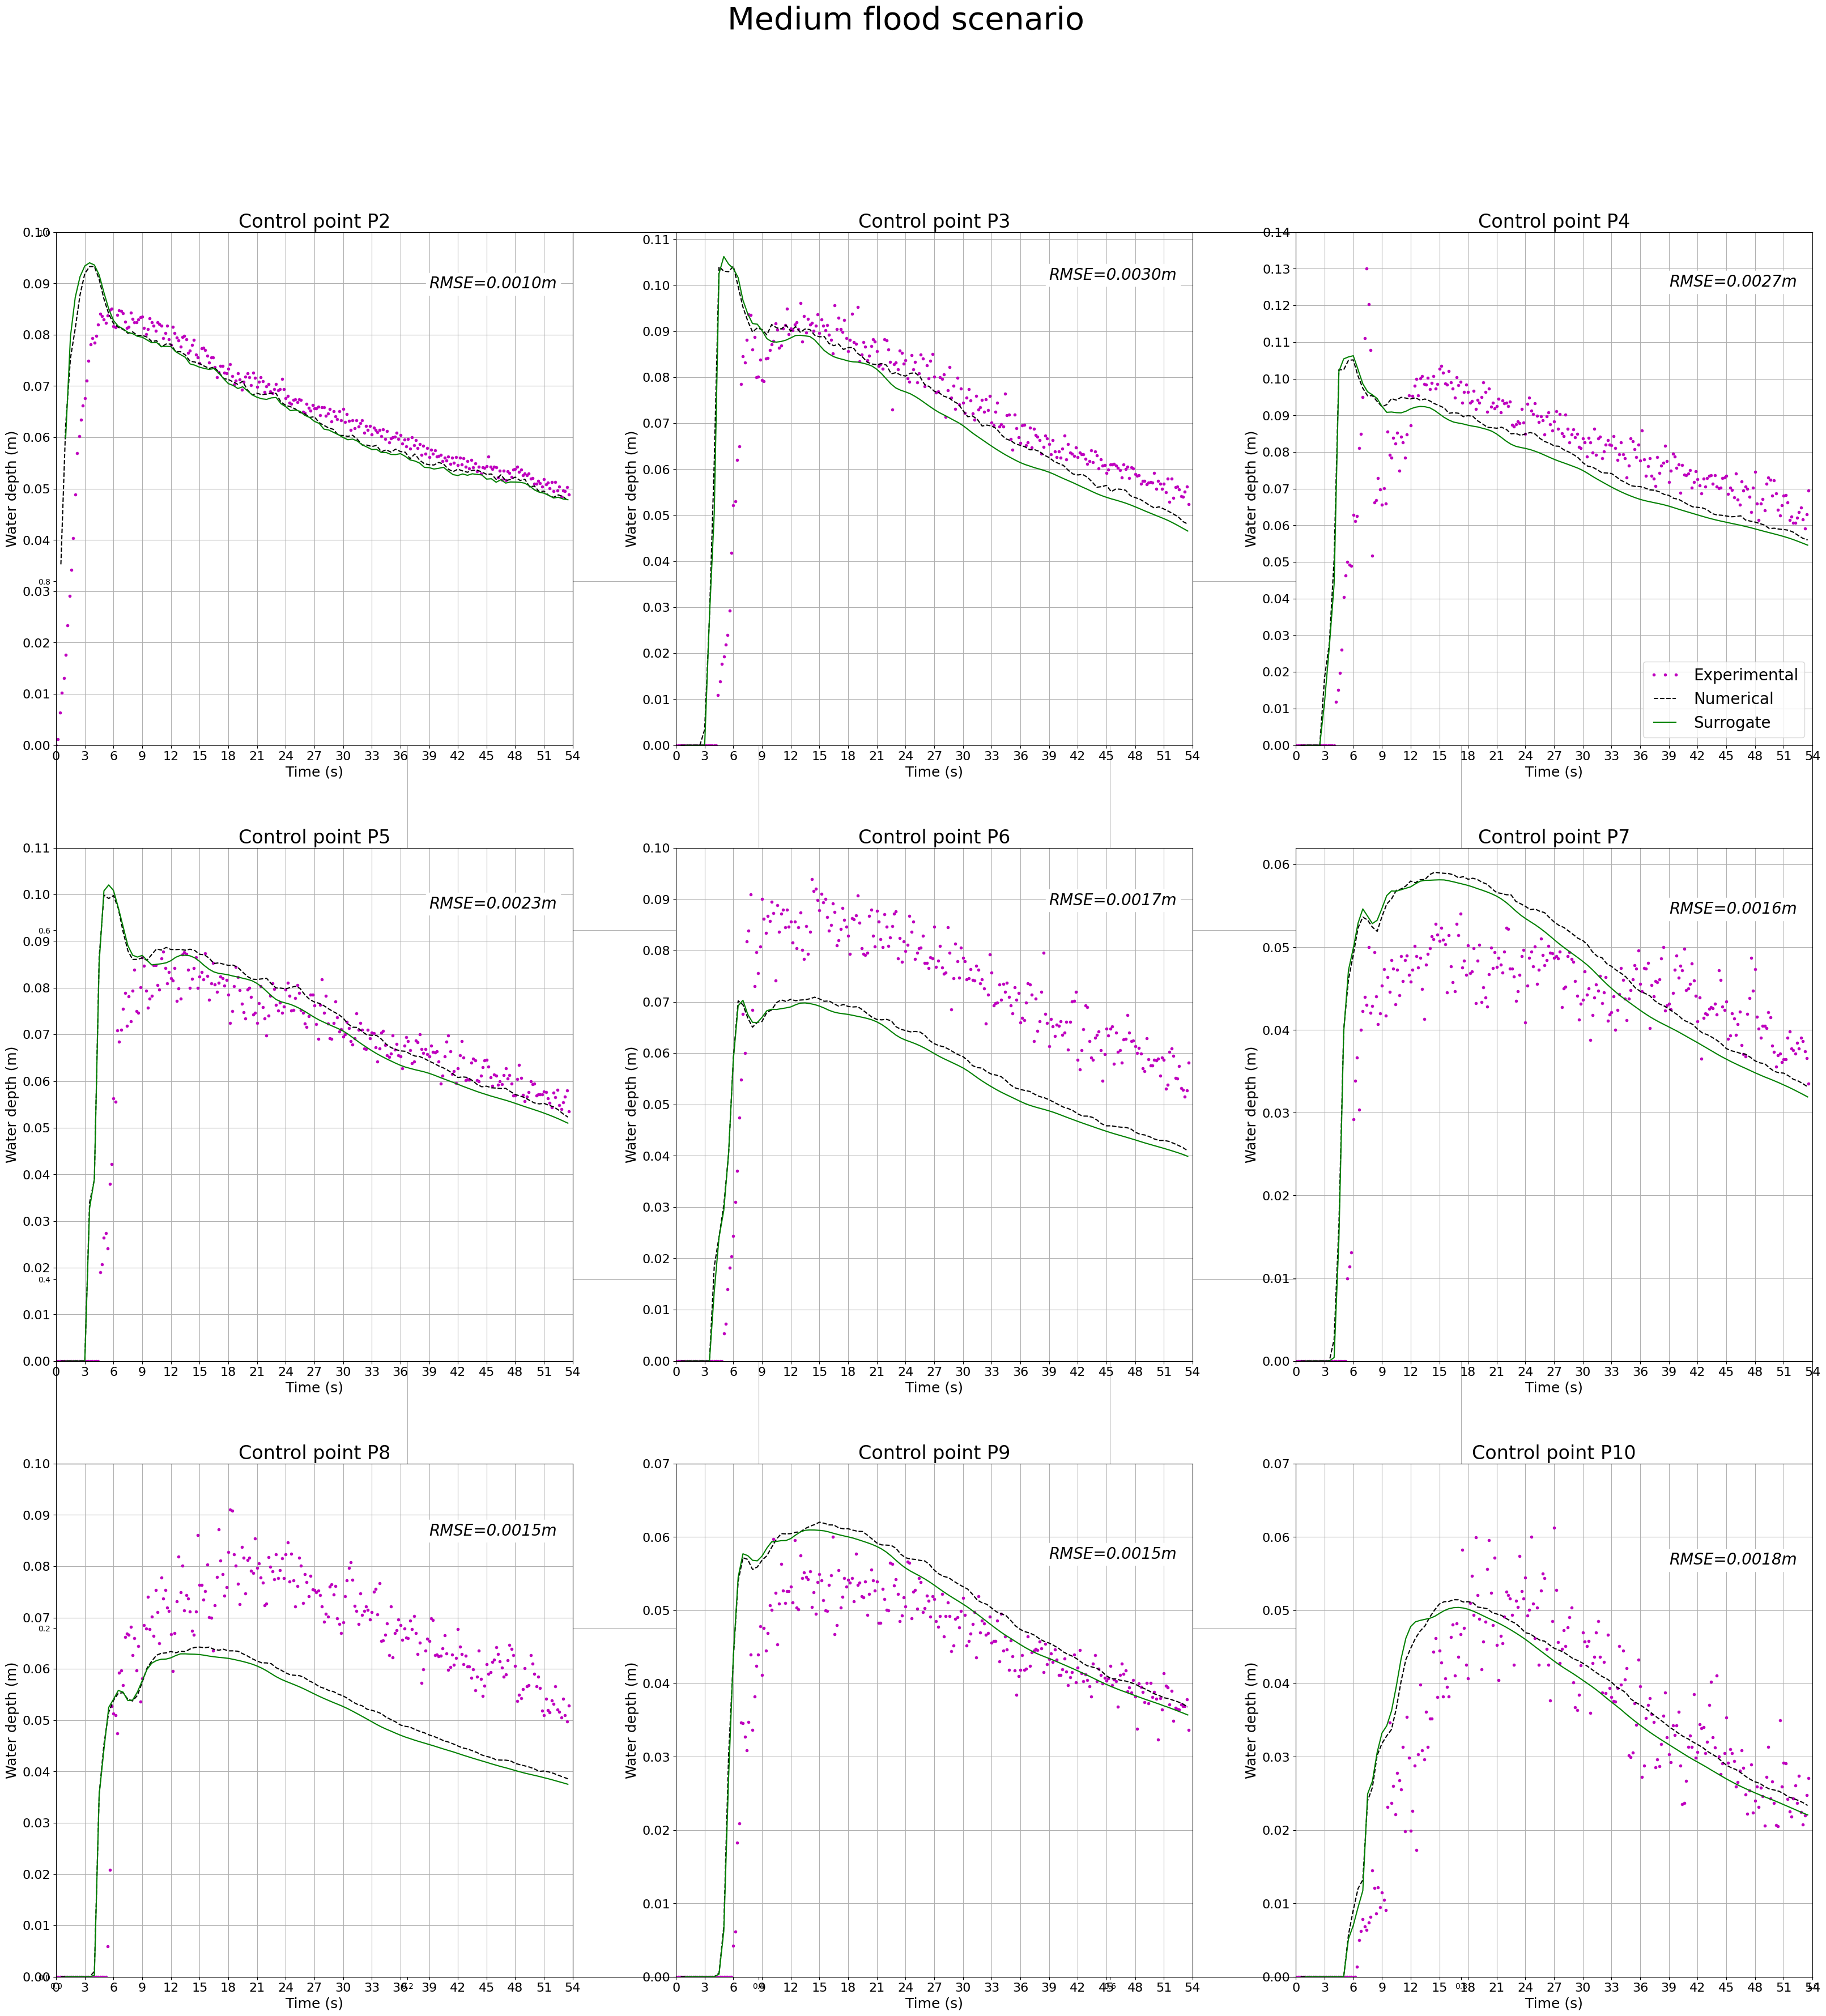

In [8]:
from docs.demo.demo_utils import extract_control_points

extract_control_points(cfg, save_dir)

***
## Download the results
The output grids (ground-truth, predicted and differences) for all the future frames are available for download from the designated output folder. \
Users have the option to manually retrieve the files or utilize the following code to download the results of the most recent run.

In [9]:
import shutil
from google.colab import files

# Create a zip file of the folder with the results of the last run.
shutil.make_archive(download_name, 'zip', save_dir)
# Download the zip file to local machine
print("Downloading {}...".format(download_name + '.zip'))
files.download(download_name + '.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>